In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [159]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')[:-1]
print(len(train_data), len(test_data))

train_copy = train_data
#test_copy = test_data.astype('float')
test_copy = test_data.apply(pd.to_numeric)

68636 29413


In [160]:
X = train_copy.drop("signal", axis=1)
X = (X-X.mean())/X.std()
train_copy = X.join(train_copy["signal"])

In [161]:
X = test_copy.drop("signal", axis=1)
X = (X-X.mean())/X.std()
test_copy = X.join(test_copy["signal"])

# Get best features

In [162]:
from scipy.stats import ks_2samp

test_stat, test_p = [], []

for i in range(len(train_copy.keys())-1):
    test_stat = np.append(test_stat,ks_2samp(train_copy.query('signal==0')[train_copy.keys()[i]],train_copy.query('signal==1')[train_copy.keys()[i]])[0])
    test_p = np.append(test_stat,ks_2samp(train_copy.query('signal==0')[train_copy.keys()[i]],train_copy.query('signal==1')[train_copy.keys()[i]])[1])
    #print(d.keys()[i+1],":",ks_2samp(d.query('signal==0')[d.keys()[i+1]],d.query('signal==1')[d.keys()[i+1]]))

test_list = dict(zip(train_copy.keys()[:-1],test_stat))
test_list_sorted = dict(sorted(test_list.items(), key=lambda item: item[1]))
test_list_sorted

{'missing_energy_phi': 0.003254063696343179,
 'lepton_phi': 0.005250537605601402,
 'jet1phi': 0.006744408012343661,
 'jet3phi': 0.007694254995927352,
 'jet4phi': 0.008105746088170163,
 'jet2phi': 0.008137114722488237,
 'm_lv': 0.010386893995635749,
 'lepton_eta': 0.010518898163357937,
 'jet1b.tag': 0.012580087397600026,
 'jet3pt': 0.012693279584993333,
 'id': 0.01269965758149394,
 'jet1eta': 0.014007216717948245,
 'jet3eta': 0.014504340101392843,
 'jet4b.tag': 0.015875851281828557,
 'jet2eta': 0.0173633309139285,
 'm_jj': 0.017681132670639033,
 'jet4eta': 0.019486671326037097,
 'jet3b.tag': 0.02494816071865935,
 'jet2pt': 0.02846273239147512,
 'jet4pt': 0.030942537809816595,
 'lepton_pT': 0.03858265522652582,
 'jet2b.tag': 0.049864347970956235,
 'm_jlv': 0.05341320850942499,
 'jet1pt': 0.06990101266799159,
 'missing_energy_magnitude': 0.07262518556598518,
 'm_jjj': 0.09632140613997875,
 'm_wbb': 0.1070652762675185,
 'm_wwbb': 0.1517473764300511,
 'm_bb': 0.1960046638615971}

Least separable: missing_energy_phi


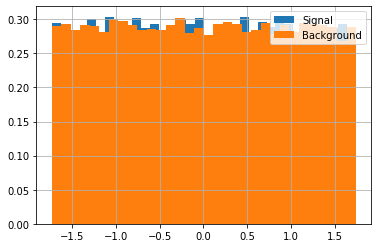

Most separable: m_bb


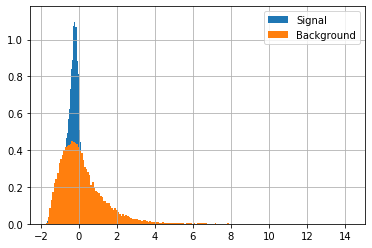

In [163]:
#print("Least separable:",train_copy.keys()[np.argmin(test_stat)+1])
#train_copy.query('signal==1')[train_copy.keys()[np.argmin(test_stat)+1]].hist(density=True,bins='auto',label="Signal")
#train_copy.query('signal==0')[train_copy.keys()[np.argmin(test_stat)+1]].hist(density=True,bins='auto',label="Background")
print("Least separable:",list(test_list_sorted.keys())[0])
train_copy.query('signal==1')[list(test_list_sorted.keys())[0]].hist(density=True,bins='auto',label="Signal")
train_copy.query('signal==0')[list(test_list_sorted.keys())[0]].hist(density=True,bins='auto',label="Background")

plt.legend()
plt.show()

#print("Most separable:",train_copy.keys()[np.argmax(test_list_sorted)+1])
#train_copy.query('signal==1')[train_copy.keys()[np.argmax(test_list_sorted)+1]].hist(density=True,bins='auto',label="Signal")
#train_copy.query('signal==0')[train_copy.keys()[np.argmax(test_list_sorted)+1]].hist(density=True,bins='auto',label="Background")
#plt.legend()
#plt.show()


print("Most separable:",list(test_list_sorted.keys())[-1])
train_copy.query('signal==1')[list(test_list_sorted.keys())[-1]].hist(density=True,bins='auto',label="Signal")
train_copy.query('signal==0')[list(test_list_sorted.keys())[-1]].hist(density=True,bins='auto',label="Background")
plt.legend()
plt.show()

# Build ANN

In [164]:
def f_act(x_input):
    return 1/(1+np.exp(-x_input))

def f_cost(y, x_input):
    return (-1/2) * (y - x_input)**2

def der_f_act(x_input):
    return np.exp(-x_input)/(1+np.exp(-x_input))**2
    #return f_act(x_input) * (1 - f_act(x_input))

def der_f_cost(y, x_input):
    return (y-x_input)

In [179]:
np.random.seed(12)


def train_ANN(input_vector,n_hidden_nodes,n_output_nodes,y_true):
    cost_all = []
    for count in range(25):

        if count==0: 
            input_weights = np.random.uniform(-1,1,[n_hidden_nodes,len(input_vector)])
            input_weights_list = input_weights

        #print(input_weights)
        hidden_inputs = np.dot(input_weights,input_vector)
        hidden_results = np.vstack((np.ones(np.shape(input_vector)[1]), f_act(hidden_inputs)))

        if count==0: 
            output_weights = np.random.uniform(-1,1,[n_output_nodes,len(hidden_results)])
            output_weights_list = output_weights[0]

        output_inputs = np.dot(output_weights, hidden_results)[0]
        output_result = f_act(output_inputs)


        prod_1 = der_f_cost(y_true,output_result) * der_f_act(output_inputs)

        for k in range(len(output_weights[0])):
           # output_weights[0][k] -= l_rate * np.sum(der_f_cost(y_true,output_result) * der_f_act(output_inputs) * 
           #                                      hidden_results[k])
            output_weights[0][k] -= l_rate * np.sum( prod_1 * hidden_results[k])

        output_weights_list = np.vstack((output_weights_list, output_weights))

        for i in range(np.shape(input_weights)[0]):
            for j in range(np.shape(input_weights)[1]):
    #            input_weights[i,j] -= l_rate * np.sum(der_f_cost(y_true,output_result) * der_f_act(output_inputs) * 
    #                                         output_weights_list[-2][i] * der_f_act(hidden_inputs[i]) * input_vector[j])
                input_weights[i,j] -= l_rate * np.sum(prod_1 * output_weights_list[-2][i] * 
                                                      der_f_act(hidden_inputs[i]) * input_vector[j])
        #input_weights_list = np.stack((input_weights_list,input_weights))

        cost_all = np.append(cost_all,np.sum(f_cost(y_true,output_result)))
        print(count,end=" ")
    
    return cost_all, input_weights, output_weights_list
    
    
    

In [180]:
#input_data = [0 * train_data['m_wbb'] + 1,train_data['m_bb'],train_data['m_wwbb'],train_data['m_wbb']]
input_vector = [0 * train_copy['m_bb'] + 1,train_copy['m_bb'],train_copy['m_wwbb'],train_copy['m_wbb']]
y_true = train_data['signal']

n_hidden_nodes = 3
n_output_nodes = 1

l_rate = 10 / 68636

cost_func, weights_L1, weights_L2 = train_ANN(input_vector,n_hidden_nodes,n_output_nodes,y_true)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 

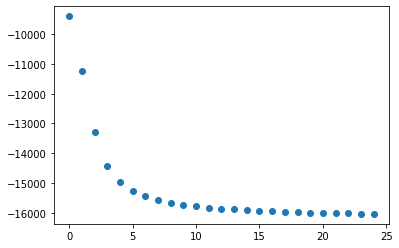

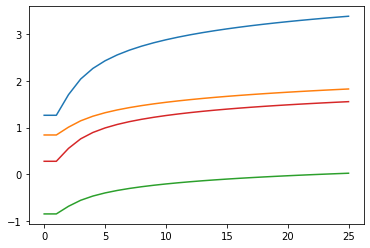

Final output weights: [3.38858714 1.82731987 0.01923149 1.55524044]


In [181]:
plt.scatter(np.arange(0,len(cost_func),1),cost_func)
plt.show()

for i in range(n_hidden_nodes+1):
    plt.plot(np.arange(0,len(weights_L2),1),weights_L2[:,i])
plt.show()

print("Final output weights:", weights_L2[-1])

In [182]:
weights_L1

array([[ 0.44164433,  0.67657283, -0.23975974,  0.17772441],
       [-0.38618895,  0.9802571 ,  0.94795096, -0.86164337],
       [ 0.66031175, -0.80579865, -0.50271844,  0.17351355]])

# Test ANN

In [183]:
#test_data


def test_ANN(input_vector, input_weights, output_weights,y_true):


    hidden_inputs = np.dot(input_weights,input_vector)
    hidden_results = np.vstack((np.ones(np.shape(input_vector)[1]), f_act(hidden_inputs)))

    
    output_inputs = np.dot(output_weights, hidden_results)[0]
    output_result = f_act(output_inputs)


        

        
    cost = np.sum(f_cost(y_true,output_result))
    
    
    return cost, output_result
    
    
    

In [184]:
test_input = [test_copy['m_bb'] * 0 + 1,test_copy['m_bb'],test_copy['m_wwbb'],test_copy['m_wbb']]
y_true = test_copy['signal']
test_cost, test_result = test_ANN(test_input, weights_L1, weights_L2,y_true)

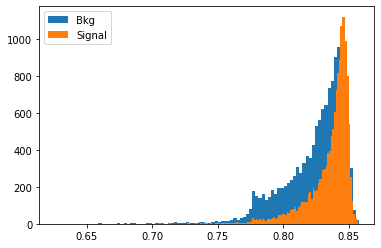

In [196]:
plt.hist(test_result[test_copy["signal"] == 0],bins='auto',label="Bkg")
plt.hist(test_result[test_copy["signal"] == 1],bins='auto',label="Signal")

plt.legend()
plt.show()

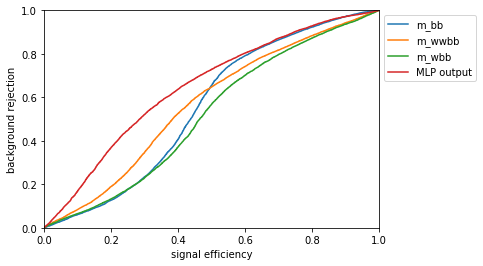

In [208]:
feats = ['m_bb','m_wwbb','m_wbb']

from sklearn.metrics import roc_curve
def left_right_ordered_feature(sample, f):
    mean_sig = np.mean(sample[f][sample["signal"] == 1])
    mean_bkg = np.mean(sample[f][sample["signal"] == 0])
    if mean_bkg < mean_sig:
        return sample[f]
    else:
        return -sample[f]

for label,value in [(f, left_right_ordered_feature(test_copy, f)) for f in feats]+[("MLP output", test_result)]:
    fpr, tpr, thresh = roc_curve(test_copy["signal"], value)
    #plt.plot(tpr, 1-fpr, label=label)
    plt.plot(fpr, tpr, label=label)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('signal efficiency')
plt.ylabel('background rejection')
plt.legend(bbox_to_anchor=(1,1), loc="upper left");
plt.show()

In [210]:
test_result

array([0.8330131 , 0.84573194, 0.84217685, ..., 0.83240255, 0.78076635,
       0.83398386])